In [1]:
import os
import cv2
import time
import random
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import deque
from datetime import datetime
from tensorflow.keras.callbacks import EarlyStopping

# Set The Hyperparameter

In [2]:
height = 256
width = 256
channels = 3
batch_size = 32
img_shape = (height, width, channels)
img_size = (height, width)

# Split The Dataset

In [3]:
DATA_DIR = '../input/workoutexercises-images'

train_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                       labels = 'inferred',
                                                       label_mode = 'categorical',
                                                       validation_split = 0.1,
                                                       subset = 'training',
                                                       image_size = img_size,
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       seed = 127
                                                      )

val_ds = tf.keras.utils.image_dataset_from_directory(DATA_DIR,
                                                     labels = 'inferred',
                                                     label_mode = 'categorical',
                                                     validation_split = 0.1,
                                                     subset = 'validation',
                                                     image_size = img_size,
                                                     shuffle = True,
                                                     batch_size = batch_size,
                                                     seed = 127
                                                    )

labels = train_ds.class_names
print(labels)

with open('workout_label.txt', 'w') as f:
    for workout_class in labels:
        f.write(f'{workout_class}\n')

Found 13853 files belonging to 22 classes.
Using 12468 files for training.
Found 13853 files belonging to 22 classes.
Using 1385 files for validation.
['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


# Data Augmentation

In [4]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                                         tf.keras.layers.GaussianNoise(10),
                                         tf.keras.layers.RandomContrast(0.1),
                                         tf.keras.layers.RandomZoom(0.2)
                                        ])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

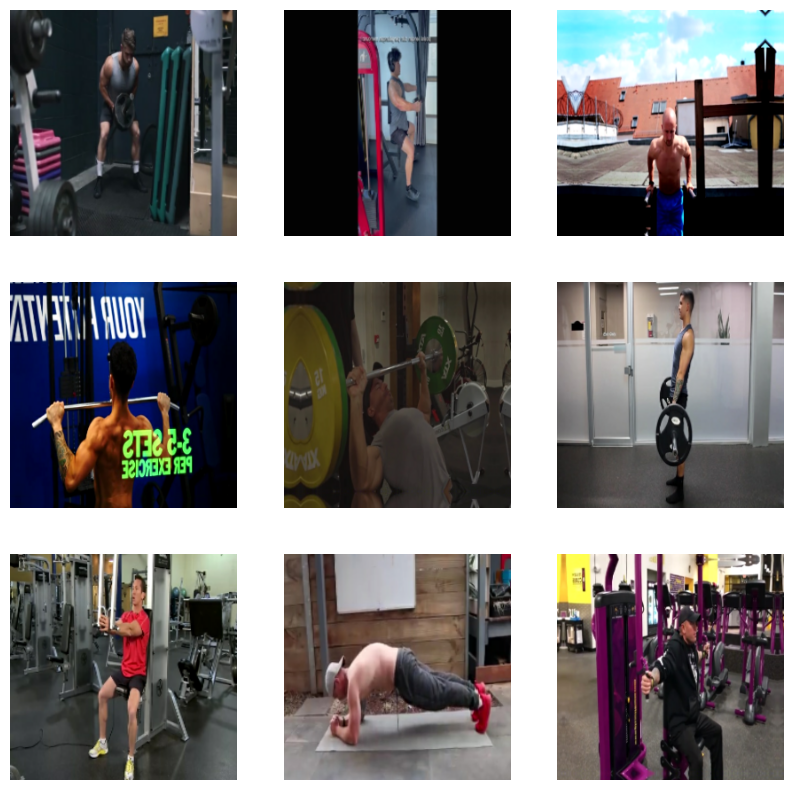

In [5]:
#Defing a function to see images
def show_img(data):
    plt.figure(figsize=(10,10))
    for images, labels in data.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")

#Plotting the images in dataset
show_img(train_ds)

# Import Pre-Trained Model

In [6]:
# load pre-trained model
pre_trained = tf.keras.applications.vgg16.VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=img_shape, 
    pooling='avg'
)

for layer in pre_trained.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 4s 0us/step


In [7]:
x = pre_trained.output

predictions = tf.keras.layers.Dense(len(labels), activation='softmax')(x)

workout_model = tf.keras.models.Model(inputs = pre_trained.input, 
                                      outputs = predictions
                                     )

workout_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy']
                     )

workout_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

# Train Model With Dataset

In [8]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', 
                                        patience = 5, 
                                        mode = 'auto', 
                                        restore_best_weights = True
                                       )

history = workout_model.fit(train_ds,
                            validation_data = val_ds,
                            epochs = 100
#                             callbacks = [early_stopping_callback]
                           )

Epoch 1/100
390/390 [==============================] - 150s 359ms/step - loss: 6.2842 - accuracy: 0.1164 - val_loss: 4.4880 - val_accuracy: 0.2217
Epoch 2/100
390/390 [==============================] - 126s 321ms/step - loss: 3.2460 - accuracy: 0.3116 - val_loss: 2.6961 - val_accuracy: 0.4195
Epoch 3/100
390/390 [==============================] - 122s 312ms/step - loss: 2.0708 - accuracy: 0.4835 - val_loss: 1.8506 - val_accuracy: 0.5495
Epoch 4/100
390/390 [==============================] - 123s 315ms/step - loss: 1.4801 - accuracy: 0.6048 - val_loss: 1.3794 - val_accuracy: 0.6318
Epoch 5/100
390/390 [==============================] - 122s 311ms/step - loss: 1.1144 - accuracy: 0.6912 - val_loss: 1.0911 - val_accuracy: 0.6975
Epoch 6/100
390/390 [==============================] - 121s 308ms/step - loss: 0.8948 - accuracy: 0.7485 - val_loss: 0.8921 - val_accuracy: 0.7487
Epoch 7/100
390/390 [==============================] - 121s 310ms/step - loss: 0.7407 - accuracy: 0.7942 - val_loss: 0

# Model Evaluation

44/44 [==============================] - 4s 81ms/step - loss: 0.1132 - accuracy: 0.9791


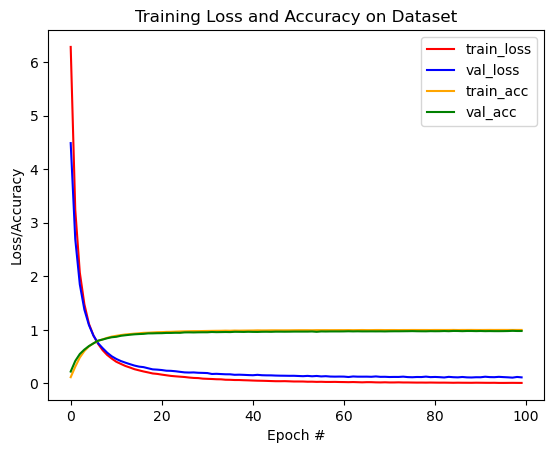

In [9]:
evaluate = workout_model.evaluate(val_ds)

epoch = range(len(history.history["loss"]))
plt.figure()
plt.plot(epoch, history.history['loss'], 'red', label = 'train_loss')
plt.plot(epoch, history.history['val_loss'], 'blue', label = 'val_loss')
plt.plot(epoch, history.history['accuracy'], 'orange', label = 'train_acc')
plt.plot(epoch, history.history['val_accuracy'], 'green', label = 'val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

# Save Model History to csv

In [10]:
hist_df = pd.DataFrame(history.history)

hist_csv_file = 'VGG16_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

# Save The Model

In [11]:
current_datetime = datetime.now()

# Save Model
workout_model.save(f'workout_model_{current_datetime}')

# Save .h5 model
workout_model.save(f'workout_model_{current_datetime}.h5')

# Convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model(f'./workout_model_{current_datetime}')
tflite_model = converter.convert()

# Save the tflite model
with open(f'workout_model_{current_datetime}.tflite', 'wb') as f:
    f.write(tflite_model)

# Testing Model

In [12]:
interpreter = tf.lite.Interpreter(model_path = f'/kaggle/working/workout_model_{current_datetime}.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_1:0
shape: [  1 256 256   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 22]
type: <class 'numpy.float32'>


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [13]:
random_classes_names = random.choice(os.listdir('/kaggle/input/workoutfitness-video'))
random_file = random.choice(os.listdir(f'/kaggle/input/workoutfitness-video/{random_classes_names}'))
print(f'{random_classes_names}/{random_file}\n')

# Construct the input video file path
input_video_file_path = f'/kaggle/input/workoutfitness-video/{random_classes_names}/{random_file}'

# import label from txt file
labels = []
with open('/kaggle/working/workout_label.txt', 'r') as f:
    for row in f:
        labels.append(row)
        

# Initialize video input
video_capture = cv2.VideoCapture(input_video_file_path)
writer = None
H, W = None, None
Q = deque(maxlen=128)
n = 0
img_size = (256, 256)

fps = video_capture.get(cv2.CAP_PROP_FPS)
frame_count = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
duration = frame_count/fps

print(f'Duration: {duration}')
print(f'FPS: {fps}')
print(f'Total frame: {frame_count}\n')

print('Prediction process')
start_time = time.time()

scan_count = 0
# Loop through each frame in the video
while True:
    # read a frame
    success, frame = video_capture.read()
    
    # if frame not read properly then break the loop
    if not success:
        break
    
    # count the frame
    n += 1
    
    if duration < 5.0:
        # predict every 10 frame (1, 11, 21, ... etc)
        step = 10
    elif duration < 10.0:
        # predict every 15 frame (1, 16, 31, ... etc)
        step = 15
    else:
        # predict every 30 frame (1, 31, 61, ... etc)
        step = 30
    
    if n % step != 1:
        continue
    
    # get frame dimensions
    if W is None or H is None:
        (H, W) = frame.shape[:2]
    
    # clone the frame for the output then preprocess the frame for the prediction
    output = frame.copy()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, img_size).astype("float32")
    
    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frame, axis=0))

    interpreter.invoke()

    predictions = interpreter.get_tensor(output_details[0]['index'])[0]
    
    Q.append(predictions)
    
    results = np.array(Q).mean(axis=0)
    i = np.argmax(results)
    label = labels[i]
    
    text = f'{label}'
#     cv2.putText(output, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 10)
    
#     if writer is None:
#         fourcc = cv2.VideoWriter_fourcc(*"XVID")
#         writer = cv2.VideoWriter('output.avi', fourcc, 30, (W, H), True)
        
#     writer.write(output)
    
#     plt.imshow(output)
#     plt.axis('off')
    
    print(f'{n}, {text}\t{results[i]}')
    scan_count += 1
    
    target_frame = int(fps*2)
    
    # break the loop if prediction > 90% and video already more than 2 seconds (fps*2)
    if results[i] >= 0.9 and n >= target_frame:
        break

end_time = time.time()

print(f'\nActual video: {random_file}')
print(f'Prediction: {text}')
print(f'confidence: {results[i]}')
print(f'Prediction time: {end_time - start_time} sec')
print(f'Scan speed: {(end_time - start_time)/scan_count} per frame\n')

# writer.release()
# video_capture.release()

result_df = pd.DataFrame({'exercise': labels,
                          'percentage': results
                         })

result_df['exercise'] = result_df['exercise'].str.strip()
result_df = result_df.sort_values('percentage', ascending=False)
result_df = result_df.reset_index(drop=True)

result_df

lateral raise/lateral raise_5.MOV

Duration: 19.516666666666666
FPS: 29.974380871050386
Total frame: 585.0

Prediction process
1, lateral raises
	0.9507762789726257
31, lateral raises
	0.942435622215271
61, lateral raises
	0.7190565466880798
91, lateral raises
	0.6231286525726318
121, shoulder press
	0.5000158548355103
151, lateral raises
	0.5709733366966248
181, lateral raises
	0.6208001375198364
211, lateral raises
	0.6517128944396973
241, lateral raises
	0.689598023891449
271, lateral raises
	0.7197239398956299
301, lateral raises
	0.7363730072975159
331, lateral raises
	0.758310854434967
361, lateral raises
	0.776901364326477
391, lateral raises
	0.7928343415260315
421, lateral raises
	0.8066380620002747
451, lateral raises
	0.8187181949615479
481, lateral raises
	0.8293814659118652
511, lateral raises
	0.8346704840660095
541, lateral raises
	0.8433719277381897
571, lateral raises
	0.8511919975280762

Actual video: lateral raise_5.MOV
Prediction: lateral raises

confidence: 0.85119

,exercise,percentage
0,lateral raises,8.511920e-01
1,shoulder press,1.478654e-01
2,t bar row,5.506355e-04
3,lat pulldown,1.565023e-04
4,hammer curl,9.861012e-05
5,tricep dips,4.446388e-05
6,leg raises,2.982880e-05
7,chest fly machine,2.481433e-05
8,squat,2.260864e-05
9,incline bench press,8.148665e-06
